In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable(logging.CRITICAL)

In [2]:
!pip install darts
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mae
from darts.metrics import mape
from darts.metrics import mse
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.explainability.tft_explainer import TFTExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.6/817.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 k

In [3]:
df = pd.read_excel("WTI.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df

,WTI,WTI_LAG,Equity Market Volatility,Economic Policy Uncertainty Europe,NY Business Conditions,3 Month Treasury Bill,Infectious Disease Tracker,Nickel,COV19,RUWAR
DATE,,,,,,,,,,
2001-10-01,-0.167019,-0.043688,22.46,141.35,-4.5,-0.72,0.39,-0.088497,0,0
2001-11-01,-0.121172,-0.167019,-13.09,-10.39,-2.2,-0.48,-0.06,-0.045894,0,0
2001-12-01,-0.012811,-0.121172,-2.94,-39.39,-6.8,-0.29,0.09,0.060355,0,0
2002-01-01,0.016876,-0.012811,-2.04,-53.76,11.7,-0.18,-0.39,0.035324,0,0
2002-02-01,0.049466,0.016876,4.29,-5.87,11.2,-0.04,0.29,0.131247,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-06-01,-0.018755,-0.104312,2.93,21.28,-42.6,0.22,2.32,-0.071308,1,1
2023-07-01,0.079594,-0.018755,-5.14,-18.30,38.4,0.02,-2.45,-0.041580,1,1
2023-08-01,0.067598,0.079594,-0.72,16.36,-5.5,0.09,-0.81,-0.006711,1,1


In [4]:
selected_columns = ["WTI","WTI_LAG","Economic Policy Uncertainty Europe","Infectious Disease Tracker"]
pruned_df = df[selected_columns]

pruned_df = pruned_df.set_index(df.index)
pruned_df

,WTI,WTI_LAG,Economic Policy Uncertainty Europe,Infectious Disease Tracker
DATE,,,,
2001-10-01,-0.167019,-0.043688,141.35,0.39
2001-11-01,-0.121172,-0.167019,-10.39,-0.06
2001-12-01,-0.012811,-0.121172,-39.39,0.09
2002-01-01,0.016876,-0.012811,-53.76,-0.39
2002-02-01,0.049466,0.016876,-5.87,0.29
...,...,...,...,...
2023-06-01,-0.018755,-0.104312,21.28,2.32
2023-07-01,0.079594,-0.018755,-18.30,-2.45
2023-08-01,0.067598,0.079594,16.36,-0.81


## Create Darts Series for Pandas DF

In [5]:
# Convert the DataFrame to a TimeSeries object
series = TimeSeries.from_dataframe(pruned_df, value_cols='WTI')
series = series.astype(np.float32)

### Splitting

In [6]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20211001")
train, val = series.split_after(training_cutoff)

### Normalization

In [7]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### Create Covariates

In [8]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="month", one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index,values=np.arange(len(series)),columns=["linear_increase"],))
covariates = covariates.astype(np.float32)

In [9]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

### Build the Self Attention Model

In [10]:
len(train_transformed)

241

In [11]:
num_samples = 242
input_chunk_length = 24
forecast_horizon = 12

In [12]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = 24
forecast_horizon = 1
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,#128
    lstm_layers=3,#3
    num_attention_heads=8,#6
    dropout=0.15,#0.2
    batch_size=4,#4
    n_epochs=60,#50
    add_relative_index=False,
    add_encoders=None, #{'cyclic': {'future': ['month']}}#0.06972
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=69,
)

### Fit the Model

In [13]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=128, lstm_layers=3, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=1, batch_size=4, n_epochs=60, add_encoders=None, random_state=69)

### Define Presentation

In [14]:
figsize = (14, 10)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## Prediction  and Rescaling

In [15]:
n=24
pred_series = my_model.predict(n=n, num_samples=num_samples)

forecast = transformer.inverse_transform(pred_series)
eval = transformer.inverse_transform(val_transformed)
st = transformer.inverse_transform(series_transformed)

Predicting: |          | 0/? [00:00<?, ?it/s]

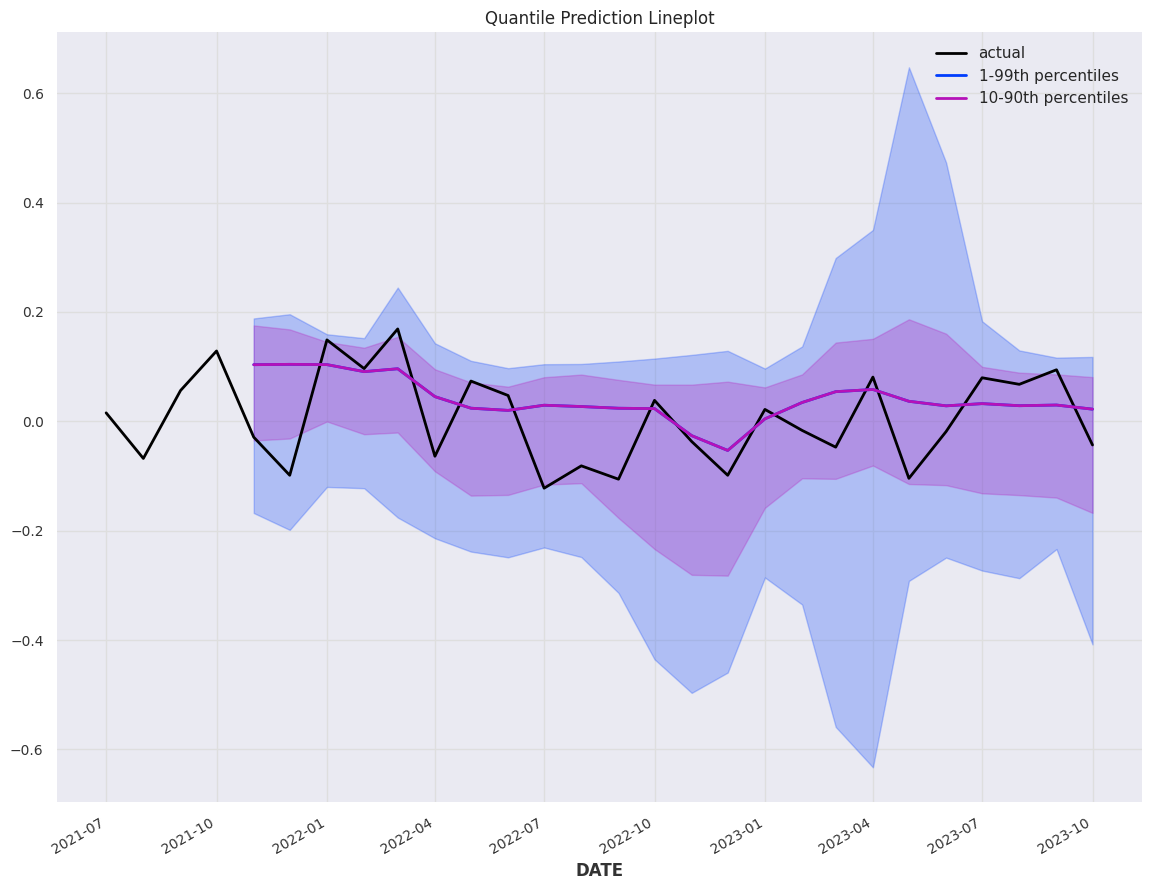

In [16]:
# Calculate the start time for the plot
plot_start_time = forecast.start_time() - (forecast.freq * 4)

# Slicing the actual series to the relevant range
series_transformed_sliced = st.slice(plot_start_time, forecast.end_time())

# plot actual series
plt.figure(figsize=figsize)
series_transformed_sliced.plot(label="actual")

# plot prediction with quantile ranges
forecast.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
forecast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title("Quantile Prediction Lineplot")
plt.legend()
plt.show()

In [17]:
print(f"MAE: {mae(eval, forecast):.4f}")
print(f"MAPE: {mape(eval, forecast):.4f} %")
print(f"MSE: {mse(eval, forecast):.4f}")
print(f"RMSE: {rmse(eval, forecast):.4f}")

MAE: 0.0709
MAPE: 120.1106 %
MSE: 0.0076
RMSE: 0.0874


## Save Prediction

In [18]:
main_prediction = forecast.quantile_timeseries(quantile=0.5)
df = main_prediction.pd_dataframe()
df=df.rename(columns={'WTI_0.5': 'WTI M TFT'})
df.to_excel("WTI_M_TFT_forecast.xlsx", index=True)
df

component,WTI M TFT
DATE,
2021-11-01,0.103508
2021-12-01,0.104136
2022-01-01,0.103636
2022-02-01,0.090797
2022-03-01,0.096073
2022-04-01,0.045096
2022-05-01,0.023962
2022-06-01,0.019949
2022-07-01,0.029393


In [19]:
# Open a file in write mode
with open('WTI M TFT Results.txt', 'w') as file:
    # Write the variables to the file
    file.write(f'{mae(eval, forecast):.4f}\n')
    file.write(f'{mape(eval, forecast):.4f}\n')
    file.write(f'{mse(eval, forecast):.4f}\n')
    file.write(f'{rmse(eval, forecast):.4f}\n')